# Price Prediction Neural Network

The notebook contains the code used to create and train the neural network which is used to predict prices for IPL auctions. The notebook also contains the code used to prepare data to be used as inputs to the network. The amount of code required to prepare the data can probably be significantly reduced/made more concise but I was lazy and copy/pasted a bunch of it, just changing variable names for each auction year.

In [1]:
# Imports and stuff

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

# Preparing the data

## 2018

The following stuff just loads in all the 2018 data and puts it into one dataframe.

In [2]:
auction_2018 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2018.csv')
auction_2018.set_index('Player', inplace=True)

# The following stats are calculates across two year intervals
# so, ipl_stats_1 contains stats calculated across the 2016 and 2017 seasons
# and ipl_stats_2 contains contains stats calculated across the 2008 to 2017 seasons
# For the it20 stats, the same follows, except the time intervals
# end the day before the auction of the 2018 ipl season

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2016_2017.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2017.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2016_2017.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2017.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
if 'Played For Country' in ipl_stats_1.columns:
    ipl_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in ipl_stats_2.columns:
    ipl_stats_2.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_1.columns:
    it20_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_2.columns:
    it20_stats_2.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Merging the dataframes
data_2018 = pd.concat([auction_2018, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)


print(data_2018.columns)
data_2018.head()

Index(['Role', 'Amount', 'Team', 'Year', 'Player Origin', 'dob',
       'Played For Country', 'ipl 1 runs', 'ipl 1 balls', 'ipl 1 4s',
       'ipl 1 6s', 'ipl 1 batting SR', 'ipl 1 batting average',
       'ipl 1 times dismissed', 'ipl 1 balls bowled', 'ipl 1 runs conceded',
       'ipl 1 wickets', 'ipl 1 economy', 'ipl 1 bowling average',
       'ipl 1 bowling SR', 'ipl 1 overs bowled', 'ipl 1 wides',
       'ipl 1 noballs', 'ipl 2 runs', 'ipl 2 balls', 'ipl 2 4s', 'ipl 2 6s',
       'ipl 2 batting SR', 'ipl 2 batting average', 'ipl 2 times dismissed',
       'ipl 2 balls bowled', 'ipl 2 runs conceded', 'ipl 2 wickets',
       'ipl 2 economy', 'ipl 2 bowling average', 'ipl 2 bowling SR',
       'ipl 2 overs bowled', 'ipl 2 wides', 'ipl 2 noballs', 'it20 1 runs',
       'it20 1 balls', 'it20 1 4s', 'it20 1 6s', 'it20 1 batting SR',
       'it20 1 batting average', 'it20 1 times dismissed',
       'it20 1 balls bowled', 'it20 1 runs conceded', 'it20 1 wickets',
       'it20 1 economy', 

,Role,Amount,Team,Year,Player Origin,dob,Played For Country,ipl 1 runs,ipl 1 balls,ipl 1 4s,...,it20 2 times dismissed,it20 2 balls bowled,it20 2 runs conceded,it20 2 wickets,it20 2 economy,it20 2 bowling average,it20 2 bowling SR,it20 2 overs bowled,it20 2 wides,it20 2 noballs
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Finch,Batsman,62000000,Kings XI Punjab,2018.0,Overseas,1986-11-17,1.0,692.0,473.0,70.0,...,27.0,6.0,9.0,0.0,9.0,NaN,NaN,1.0,0.0,0.0
Abhishek Sharma,All-Rounder,5500000,Delhi Daredevils,2018.0,Indian,2000-09-04,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Aditya Tare,Wicket Keeper,2000000,Mumbai Indians,2018.0,Indian,1987-11-07,0.0,26.0,38.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ajinkya Rahane,Batsman,40000000,Rajasthan Royals,2018.0,Indian,1988-06-06,1.0,862.0,701.0,89.0,...,17.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0
Akila Dhananjaya,Bowler,5000000,Mumbai Indians,2018.0,Overseas,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Now let's convert DOB to age at time of auction

auction_date = pd.to_datetime('2018-01-27')
data_2018['Age'] = (auction_date - pd.to_datetime(data_2018['dob'])).dt.days // 365

# Drop the DOB column
data_2018.drop('dob', axis=1, inplace=True)

# I'm just going to replace missing ages with the mean age (for now at least)
data_2018['Age'].fillna(data_2018['Age'].mean(), inplace=True)

print(data_2018['Age'].describe())

count    169.000000
mean      26.944056
std        4.579686
min       17.000000
25%       25.000000
50%       26.944056
75%       29.000000
max       43.000000
Name: Age, dtype: float64


In [4]:
# Deal with missing values
data_2018.fillna(0, inplace=True)
data_2018.isnull().sum()

Role                   0
Amount                 0
Team                   0
Year                   0
Player Origin          0
                      ..
it20 2 bowling SR      0
it20 2 overs bowled    0
it20 2 wides           0
it20 2 noballs         0
Age                    0
Length: 71, dtype: int64

In [5]:
# Drop the 'Team' column
data_2018.drop('Team', axis=1, inplace=True)

# Add dummy variables for 'Role' and 'Player Origin'
data_2018 = pd.get_dummies(data_2018, columns=['Role', 'Player Origin'])

*Do the same as above for the next auctions*

## 2019

In [6]:
auction_2019 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2019.csv')
auction_2019.set_index('Player', inplace=True)

# The following stats are calculates across two year intervals
# so, ipl_stats_1 contains stats calculated across the 2016 and 2017 seasons
# and ipl_stats_2 contains stats calculated across the 2014 and 2015 seasons
# For the it20 stats, the same follows, except the two year interval\
# ends the day before the auction of the 2018 ipl season

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2017_2018.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2018.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2017_2018.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2018.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
if 'Played For Country' in ipl_stats_1.columns:
    ipl_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in ipl_stats_2.columns:
    ipl_stats_2.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_1.columns:
    it20_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_2.columns:
    it20_stats_2.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Merging the dataframes
data_2019 = pd.concat([auction_2019, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

data_2019.head()

,Role,Amount,Team,Year,Player Origin,Played For Country,dob,ipl 1 runs,ipl 1 balls,ipl 1 4s,...,it20 2 times dismissed,it20 2 balls bowled,it20 2 runs conceded,it20 2 wickets,it20 2 economy,it20 2 bowling average,it20 2 bowling SR,it20 2 overs bowled,it20 2 wides,it20 2 noballs
Player,,,,,,,,,,,,,,,,,,,,,
Agnivesh Ayachi,All-Rounder,2000000,Kings XI Punjab,2019.0,Indian,0.0,1995-06-15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akshdeep Nath,All-Rounder,36000000,Royal Challengers Bangalore,2019.0,Indian,0.0,1993-05-10,9.0,14.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ankush Bains,Wicket Keeper,2000000,Delhi Capitals,2019.0,Indian,0.0,1995-12-16,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anmolpreet Singh,Batsman,8000000,Mumbai Indians,2019.0,Indian,0.0,1998-03-28,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anrich Nortje,Bowler,2000000,Kolkata Knight Riders,2019.0,Overseas,0.0,1993-11-16,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Now let's convert DOB to age at time of auction

auction_date = pd.to_datetime('2018-12-18')
data_2019['Age'] = (auction_date - pd.to_datetime(data_2019['dob'])).dt.days // 365

# Drop the DOB column
data_2019.drop('dob', axis=1, inplace=True)

# I'm just going to replace missing ages with the mean age (for now at least)
data_2019['Age'].fillna(data_2019['Age'].mean(), inplace=True)

print(data_2019['Age'].describe())

count    60.000000
mean     25.392157
std       4.337766
min      17.000000
25%      22.750000
50%      25.392157
75%      28.000000
max      35.000000
Name: Age, dtype: float64


In [8]:
# Deal with missing values
data_2019.fillna(0, inplace=True)
data_2019.isnull().sum()

Role                   0
Amount                 0
Team                   0
Year                   0
Player Origin          0
                      ..
it20 2 bowling SR      0
it20 2 overs bowled    0
it20 2 wides           0
it20 2 noballs         0
Age                    0
Length: 71, dtype: int64

In [9]:
# Drop the 'Team' column
data_2019.drop('Team', axis=1, inplace=True)

# Add dummy variables for 'Role' and 'Player Origin'
data_2019 = pd.get_dummies(data_2019, columns=['Role', 'Player Origin'])

## 2020

In [10]:
auction_2020 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2020.csv')
auction_2020.set_index('Player', inplace=True)

# The following stats are calculates across two year intervals
# so, ipl_stats_1 contains stats calculated across the 2016 and 2017 seasons
# and ipl_stats_2 contains stats calculated across the 2014 and 2015 seasons
# For the it20 stats, the same follows, except the two year interval\
# ends the day before the auction of the 2018 ipl season

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2018_2019.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2019.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2018_2019.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2019.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
if 'Played For Country' in ipl_stats_1.columns:
    ipl_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in ipl_stats_2.columns:
    ipl_stats_2.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_1.columns:
    it20_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_2.columns:
    it20_stats_2.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Merging the dataframes
data_2020 = pd.concat([auction_2020, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

data_2020.head()

,Role,Amount,Team,Year,Player Origin,Played For Country,dob,ipl 1 runs,ipl 1 balls,ipl 1 4s,...,it20 2 times dismissed,it20 2 balls bowled,it20 2 runs conceded,it20 2 wickets,it20 2 economy,it20 2 bowling average,it20 2 bowling SR,it20 2 overs bowled,it20 2 wides,it20 2 noballs
Player,,,,,,,,,,,,,,,,,,,,,
Aaron Finch,Batsman,44000000,Royal Challengers Bangalore,2020.0,Overseas,1.0,1986-11-17,134.0,100.0,6.0,...,45.0,6.0,9.0,0.0,9.00,NaN,NaN,1.00,0.0,0.0
Abdul Samad,All-Rounder,2000000,Sunrisers Hyderabad,2020.0,Indian,0.0,2004-06-15,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akash Singh,Bowler,2000000,Rajasthan Royals,2020.0,Indian,0.0,1995-12-20,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Alex Carey,Wicket Keeper,24000000,Delhi Capitals,2020.0,Overseas,1.0,1991-08-27,NaN,NaN,NaN,...,8.0,0.0,0.0,0.0,NaN,NaN,NaN,0.00,0.0,0.0
Andrew Tye,Bowler,10000000,Rajasthan Royals,2020.0,Overseas,1.0,1986-12-12,32.0,40.0,2.0,...,6.0,576.0,816.0,37.0,8.89,22.05,15.57,91.83,21.0,4.0


In [11]:
# Now let's convert DOB to age at time of auction

auction_date = pd.to_datetime('2019-12-19')
data_2020['Age'] = (auction_date - pd.to_datetime(data_2020['dob'])).dt.days // 365

# Drop the DOB column
data_2020.drop('dob', axis=1, inplace=True)

# I'm just going to replace missing ages with the mean age (for now at least)
data_2020['Age'].fillna(data_2020['Age'].mean(), inplace=True)

print(data_2020['Age'].describe())

count    61.000000
mean     26.537037
std       5.445833
min      15.000000
25%      23.000000
50%      26.537037
75%      30.000000
max      48.000000
Name: Age, dtype: float64


In [12]:
# Deal with missing values
data_2020.fillna(0, inplace=True)
data_2020.isnull().sum()

Role                   0
Amount                 0
Team                   0
Year                   0
Player Origin          0
                      ..
it20 2 bowling SR      0
it20 2 overs bowled    0
it20 2 wides           0
it20 2 noballs         0
Age                    0
Length: 71, dtype: int64

In [13]:
# Drop the 'Team' column
data_2020.drop('Team', axis=1, inplace=True)

# Add dummy variables for 'Role' and 'Player Origin'
data_2020 = pd.get_dummies(data_2020, columns=['Role', 'Player Origin'])

## Merging the years

In [14]:
# Add a column specifying the year of the auction and the minimum auction price
data_2018['Year'] = 2018
data_2018['Salary Cap (Crore)'] = 80
data_2019['Year'] = 2019
data_2019['Salary Cap (Crore)'] = 82
data_2020['Year'] = 2020
data_2020['Salary Cap (Crore)'] = 85

In [15]:
# Turn index into a column
data_2018.reset_index(inplace=True)
data_2019.reset_index(inplace=True)
data_2020.reset_index(inplace=True)

# Concatenate the two dataframes 
data = pd.concat([data_2018, data_2019, data_2020], axis=0, sort=False)

# Remove player column
data.drop('Player', axis=1, inplace=True)

print(f'{len(data_2018)} + {len(data_2019)} + {len(data_2020)}= {len(data)}')
data.head()

169 + 60 + 61= 290


,Amount,Year,Played For Country,ipl 1 runs,ipl 1 balls,ipl 1 4s,ipl 1 6s,ipl 1 batting SR,ipl 1 batting average,ipl 1 times dismissed,...,it20 2 wides,it20 2 noballs,Age,Role_All-Rounder,Role_Batsman,Role_Bowler,Role_Wicket Keeper,Player Origin_Indian,Player Origin_Overseas,Salary Cap (Crore)
0,62000000,2018,1.0,692.0,473.0,70.0,30.0,146.30,32.95,21.0,...,0.0,0.0,31.000000,False,True,False,False,False,True,80
1,5500000,2018,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,17.000000,True,False,False,False,True,False,80
2,2000000,2018,0.0,26.0,38.0,4.0,0.0,68.42,5.20,5.0,...,0.0,0.0,30.000000,False,False,False,True,True,False,80
3,40000000,2018,1.0,862.0,701.0,89.0,18.0,122.97,33.15,26.0,...,0.0,0.0,29.000000,False,True,False,False,True,False,80
4,5000000,2018,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,...,0.0,0.0,26.944056,False,False,True,False,False,True,80


# Neural Network

In [16]:
# Split into train and test
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
x_train, x_test, y_train, y_test = train_test_split(data.drop('Amount', axis=1), data['Amount'], test_size=0.3, random_state=42)

# Converting values to numpy floats
x_train = x_train.values.astype("float32")
x_test = x_test.values.astype("float32")
y_train = y_train.values.astype("float32")
y_test = y_test.values.astype("float32")

# Reserve 10% of the training data for validation
x_val = x_train[-(int(0.1 * len(x_train))):]
y_val = y_train[-(int(0.1 * len(y_train))):]
x_train = x_train[:-(int(0.1 * len(x_train)))]
y_train = y_train[:-(int(0.1 * len(y_train)))]

# Create the model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(25, activation=tf.nn.relu, input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(20, activation=tf.nn.relu, input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(20, activation=tf.nn.relu, input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(5, activation=tf.nn.relu, input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(x_train.shape[1:])),
    tf.keras.layers.Dense(1) # ouput
])

# I use a callback to stop training early when the validation loss stops decreasing
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.02), # Using the Adam optimizer
    loss=tf.keras.losses.MeanAbsolutePercentageError(), # Mean Absolute Percentage Error
    metrics=[tf.keras.metrics.MeanAbsoluteError()]
)

print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=8,
    epochs=400,
    validation_data=(x_val, y_val),
    callbacks=[callback]
)

Fit model on training data
Epoch 1/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 98.4752 - mean_absolute_error: 19686712.0000 - val_loss: 67.6208 - val_mean_absolute_error: 21834748.0000
Epoch 2/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 62.7023 - mean_absolute_error: 21292048.0000 - val_loss: 63.3530 - val_mean_absolute_error: 21267170.0000
Epoch 3/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 58.9154 - mean_absolute_error: 23238968.0000 - val_loss: 59.3008 - val_mean_absolute_error: 21155980.0000
Epoch 4/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 54.3741 - mean_absolute_error: 20270720.0000 - val_loss: 59.7219 - val_mean_absolute_error: 21678096.0000
Epoch 5/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 54.3336 - mean_absolute_error: 18178834.0000 - val_loss: 59.7236 - val_mean_absolute_error: 21245554.0000
Epoch 6/400
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 55.2995 - mean_absolute_error: 18737772.0000 - val_loss: 59.1258 - val_mean_absolute_err

In [17]:
print("Evaluate on test data")
results = model.evaluate(x_test, y_test, batch_size=8)
print("test loss, test mae:", results)

# Generate predictions
print("Generate predictions for 3 samples")
predictions = model.predict(x_test[:3])
print("predictions shape:", predictions.shape)

Evaluate on test data
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60.8983 - mean_absolute_error: 19246540.0000 
test loss, test mae: [63.17184066772461, 18703772.0]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
predictions shape: (3, 1)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


TypeError: functools.partial(<class 'matplotlib.lines.Line2D'>, xdata=[], ydata=[]) got multiple values for keyword argument 'label'

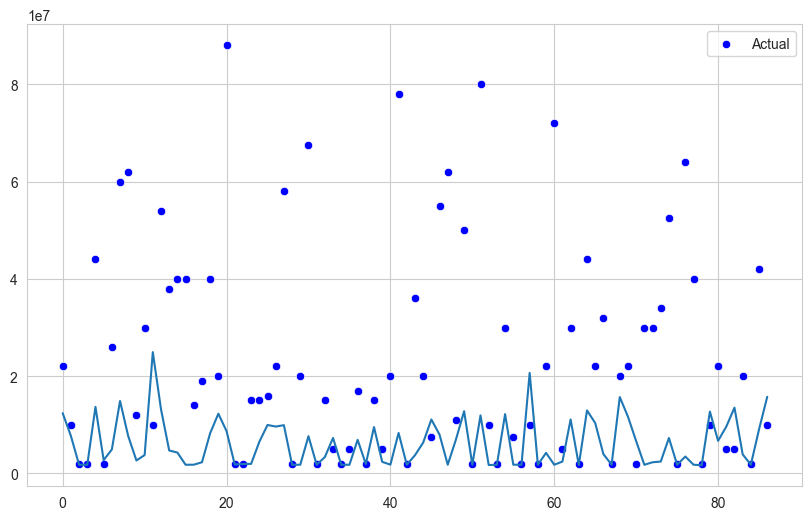

In [18]:
y_pred = model.predict(x_test)

# Plot the predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(data=y_test, label='Actual', color='blue')
sns.lineplot(data=y_pred, label='Predicted', color='red')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.xlim(0, 1e8)
plt.ylim(0, 1e8)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# Distribution of the actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True)
sns.histplot(y_pred, color='red', label='Predicted', kde=True)
plt.title('Distribution of Actual and Predicted Values')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# 2024 Predictions

This section of the notebook contains code used to predict prices for players in the 2024 auction list. These prices are then used in the ipl teampicker program.

## Preparing the data

In [ ]:
auction_2024 = pd.read_csv('data/2024/ipl_auction_2024.csv')
auction_2024.set_index('Player', inplace=True)

# Load in the stats
ipl_stats_1 = pd.read_csv('data/2024/ipl_stats_2022_2023.csv')
ipl_stats_2 = pd.read_csv('data/2024/ipl_stats_2008_2023.csv')
it20_stats_1 = pd.read_csv('data/2024/it20_stats_2022_2023.csv')
it20_stats_2 = pd.read_csv('data/2024/it20_stats_2005_2023.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
if 'Played For Country' in ipl_stats_1.columns:
    ipl_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in ipl_stats_2.columns:
    ipl_stats_2.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_1.columns:
    it20_stats_1.drop('Played For Country', axis=1, inplace=True)
if 'Played For Country' in it20_stats_2.columns:
    it20_stats_2.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Merging the dataframes
data_2024 = pd.concat([auction_2024, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

print(data_2024.columns)
data_2024.head()

Index(['Player Origin', 'Role', 'Played For Country', 'dob', 'ipl 1 runs',
       'ipl 1 balls', 'ipl 1 4s', 'ipl 1 6s', 'ipl 1 batting SR',
       'ipl 1 batting average', 'ipl 1 times dismissed', 'ipl 1 balls bowled',
       'ipl 1 runs conceded', 'ipl 1 wickets', 'ipl 1 economy',
       'ipl 1 bowling average', 'ipl 1 bowling SR', 'ipl 1 overs bowled',
       'ipl 1 wides', 'ipl 1 noballs', 'ipl 2 runs', 'ipl 2 balls', 'ipl 2 4s',
       'ipl 2 6s', 'ipl 2 batting SR', 'ipl 2 batting average',
       'ipl 2 times dismissed', 'ipl 2 balls bowled', 'ipl 2 runs conceded',
       'ipl 2 wickets', 'ipl 2 economy', 'ipl 2 bowling average',
       'ipl 2 bowling SR', 'ipl 2 overs bowled', 'ipl 2 wides',
       'ipl 2 noballs', 'it20 1 runs', 'it20 1 balls', 'it20 1 4s',
       'it20 1 6s', 'it20 1 batting SR', 'it20 1 batting average',
       'it20 1 times dismissed', 'it20 1 balls bowled', 'it20 1 runs conceded',
       'it20 1 wickets', 'it20 1 economy', 'it20 1 bowling average',
       

,Player Origin,Role,Played For Country,dob,ipl 1 runs,ipl 1 balls,ipl 1 4s,ipl 1 6s,ipl 1 batting SR,ipl 1 batting average,...,it20 2 times dismissed,it20 2 balls bowled,it20 2 runs conceded,it20 2 wickets,it20 2 economy,it20 2 bowling average,it20 2 bowling SR,it20 2 overs bowled,it20 2 wides,it20 2 noballs
Player,,,,,,,,,,,,,,,,,,,,,
Abid Mushtaq,Indian,All-Rounder,0.0,1997-01-17,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Akash Singh,Indian,Bowler,0.0,1995-12-20,0.0,0.0,0.0,0.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Angkrish Raghuvanshi,Indian,Batter,0.0,2005-06-05,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anshul Kamboj,Indian,All-Rounder,0.0,2000-12-06,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Arshin Kulkarni,Indian,All-Rounder,0.0,2005-02-15,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Now let's convert DOB to age at time of auction

auction_date = pd.to_datetime('2023-12-19')
data_2024['Age'] = (auction_date - pd.to_datetime(data_2024['dob'])).dt.days // 365

# Drop the DOB column
data_2024.drop('dob', axis=1, inplace=True)

# I'm just going to replace missing ages with the mean age (for now at least)
data_2024['Age'].fillna(data_2024['Age'].mean(), inplace=True)

print(data_2024['Age'].describe())

count    332.000000
mean      27.225000
std        4.351207
min       16.000000
25%       25.000000
50%       27.225000
75%       30.000000
max       43.000000
Name: Age, dtype: float64


In [ ]:
# Deal with missing values
data_2024.fillna(0, inplace=True)
data_2024.isnull().sum()

Player Origin          0
Role                   0
Played For Country     0
ipl 1 runs             0
ipl 1 balls            0
                      ..
it20 2 bowling SR      0
it20 2 overs bowled    0
it20 2 wides           0
it20 2 noballs         0
Age                    0
Length: 68, dtype: int64

In [ ]:
print(data_2024.columns)

Index(['Year', 'Played For Country', 'ipl 1 runs', 'ipl 1 balls', 'ipl 1 4s',
       'ipl 1 6s', 'ipl 1 batting SR', 'ipl 1 batting average',
       'ipl 1 times dismissed', 'ipl 1 balls bowled', 'ipl 1 runs conceded',
       'ipl 1 wickets', 'ipl 1 economy', 'ipl 1 bowling average',
       'ipl 1 bowling SR', 'ipl 1 overs bowled', 'ipl 1 wides',
       'ipl 1 noballs', 'ipl 2 runs', 'ipl 2 balls', 'ipl 2 4s', 'ipl 2 6s',
       'ipl 2 batting SR', 'ipl 2 batting average', 'ipl 2 times dismissed',
       'ipl 2 balls bowled', 'ipl 2 runs conceded', 'ipl 2 wickets',
       'ipl 2 economy', 'ipl 2 bowling average', 'ipl 2 bowling SR',
       'ipl 2 overs bowled', 'ipl 2 wides', 'ipl 2 noballs', 'it20 1 runs',
       'it20 1 balls', 'it20 1 4s', 'it20 1 6s', 'it20 1 batting SR',
       'it20 1 batting average', 'it20 1 times dismissed',
       'it20 1 balls bowled', 'it20 1 runs conceded', 'it20 1 wickets',
       'it20 1 economy', 'it20 1 bowling average', 'it20 1 bowling SR',
       'it

In [ ]:
print(data_2024)

                      Year  Played For Country  ipl 1 runs  ipl 1 balls  \
Player                                                                    
Abid Mushtaq          2024                 0.0         0.0          0.0   
Akash Singh           2024                 0.0         0.0          0.0   
Angkrish Raghuvanshi  2024                 0.0         0.0          0.0   
Anshul Kamboj         2024                 0.0         0.0          0.0   
Arshin Kulkarni       2024                 0.0         0.0          0.0   
...                    ...                 ...         ...          ...   
Jagadeesha Suchith    2024                 0.0         2.0          8.0   
B. Surya              2024                 0.0         0.0          0.0   
Pankaj Yadav          2024                 0.0         0.0          0.0   
Sahil Dhiwan          2024                 0.0         0.0          0.0   
Kaushal Tambe         2024                 0.0         0.0          0.0   

                      ip

11/11 [==============================] - 0s 1ms/step


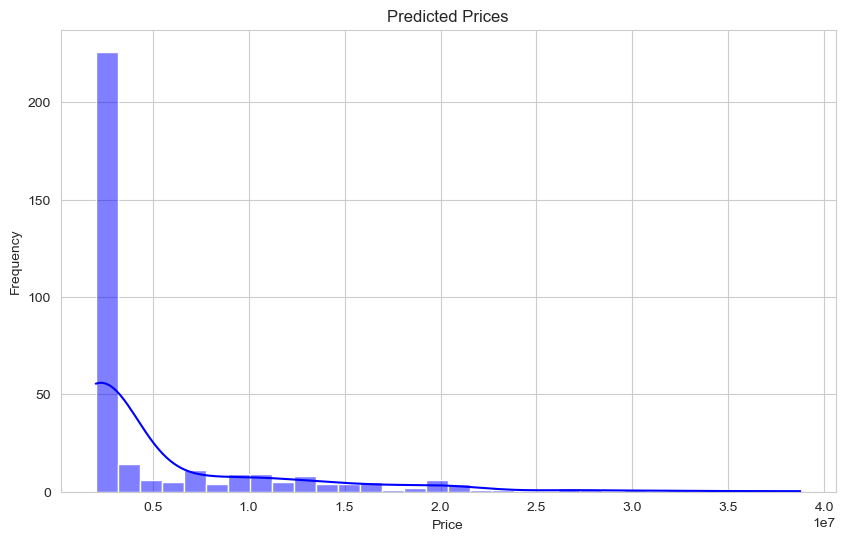

In [ ]:
# Convert to numpy arrays
X = data_2024.values.astype("float32")

# Generate predictions
predictions = model.predict(X)
predictions = pd.Series(predictions.flatten())

# Plot the predictions
plt.figure(figsize=(10, 6))
sns.histplot(predictions, color='blue', kde=True)
plt.title('Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Get indexes as a series
players = data_2024.index.to_series()
print(players)

Player
Abid Mushtaq                    Abid Mushtaq
Akash Singh                      Akash Singh
Angkrish Raghuvanshi    Angkrish Raghuvanshi
Anshul Kamboj                  Anshul Kamboj
Arshin Kulkarni              Arshin Kulkarni
                                ...         
Jagadeesha Suchith        Jagadeesha Suchith
B. Surya                            B. Surya
Pankaj Yadav                    Pankaj Yadav
Sahil Dhiwan                    Sahil Dhiwan
Kaushal Tambe                  Kaushal Tambe
Name: Player, Length: 332, dtype: object


In [ ]:
predicted_prices = pd.DataFrame()
predicted_prices['Player'] = data_2024.index.to_list()
predicted_prices['Amount'] = predictions
predicted_prices.head()

,Player,Amount
0,Abid Mushtaq,2108533.00
1,Akash Singh,3987720.50
2,Angkrish Raghuvanshi,2105171.50
3,Anshul Kamboj,2105053.25
4,Arshin Kulkarni,2099252.50


In [ ]:
# Save to csv
predicted_prices.to_csv('data/predicted_prices_2024.csv', index=False)

In [ ]:
auction_pool_2024 = pd.read_csv('../ipl-teampicker/2024_auction_pool_mock.csv')
auction_pool_2024['Price'] = predictions
# Save to csv
auction_pool_2024.to_csv('../ipl-teampicker/2024_auction_pool_with_prices.csv', index=False)

XGboost

In [ ]:
data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data.drop('Amount', axis=1), data['Amount'], test_size=0.3, random_state=42)

# Convert to numpy arrays
x_train = x_train.values.astype("float32")
x_test = x_test.values.astype("float32")
y_train = y_train.values.astype("float32")
y_test = y_test.values.astype("float32")

# Reserve 10% of the training data for validation
x_val = x_train[-(int(0.1 * len(x_train))):]
y_val = y_train[-(int(0.1 * len(y_train))):]
x_train = x_train[:-(int(0.1 * len(x_train)))]
y_train = y_train[:-(int(0.1 * len(y_train)))]

In [ ]:
# Parameters 
params = {
    'eta': 0.36350116814977074,
    'max_depth': 0,
    'subsample': 0.9437387635495996,
    'colsample_bytree': 0.7484682050306589,
    'gamma': 0.3305716445029222,
    'lambda': 0.7076261492312568,
    'alpha': 0.5654945293943124,
    'min_child_weight': 5.861342155214897,
    'objective': 'reg:squarederror'
}

# Convert the datasets into DMatrix
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)
dtest = xgb.DMatrix(x_test, label=y_test)

# Train the model
num_round = 100
evallist = [(dtrain, 'train'), (dval, 'eval')]
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=15)


[0]	train-rmse:23986097.35688	eval-rmse:31217924.32394
[1]	train-rmse:21225421.70070	eval-rmse:29044438.64172


[2]	train-rmse:19356987.70225	eval-rmse:27682481.05051
[3]	train-rmse:17595604.86856	eval-rmse:27208063.24867
[4]	train-rmse:16386956.47326	eval-rmse:26615173.67936
[5]	train-rmse:15325567.01410	eval-rmse:27702970.07547
[6]	train-rmse:14449979.62495	eval-rmse:27887996.51822
[7]	train-rmse:13466870.51633	eval-rmse:26584078.54114
[8]	train-rmse:12723726.53791	eval-rmse:27230931.33775
[9]	train-rmse:12153792.66867	eval-rmse:26819653.34833
[10]	train-rmse:11690707.67117	eval-rmse:26553151.26668
[11]	train-rmse:11266475.13916	eval-rmse:26379800.98717
[12]	train-rmse:10940827.73034	eval-rmse:25819084.66696
[13]	train-rmse:10514902.10445	eval-rmse:25588502.34544
[14]	train-rmse:10213500.93212	eval-rmse:25485266.37450
[15]	train-rmse:9943346.80270	eval-rmse:25379836.70291
[16]	train-rmse:9664707.63421	eval-rmse:25732471.12229
[17]	train-rmse:9463767.96839	eval-rmse:25655134.07393
[18]	train-rmse:9313404.29091	eval-rmse:25930002.33207
[19]	train-rmse:9146098.28570	eval-rmse:26117746.64511
[20]	

In [ ]:
# Make predictions on the test set
preds = bst.predict(dtest)

# Evaluate the model using RMSE
rmse = np.sqrt(mean_squared_error(y_test, preds))
print(f"RMSE: {rmse}")

mean_price = np.mean(y_test)
median_price = np.median(y_test)

print(f'Mean Price: {mean_price}')
print(f'Median Price: {median_price}')

# Calculate relative RMSE
relative_rmse = rmse / mean_price
print(f'Relative RMSE: {relative_rmse}')



RMSE: 25831080.0
Mean Price: 23620688.0
Median Price: 19000000.0
Relative RMSE: 1.0935786962509155


In [ ]:
auction_2024 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2024.csv')
auction_2024.set_index('Player', inplace=True)

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2022_2023.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2023.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2022_2023.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2023.csv')

# Index by player name
ipl_stats_1.set_index('Player', inplace=True)
ipl_stats_2.set_index('Player', inplace=True)
it20_stats_1.set_index('Player', inplace=True)
it20_stats_2.set_index('Player', inplace=True)

# Drop played for country column if it exists
for df in [ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2]:
    if 'Played For Country' in df.columns:
        df.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

auction_2024.reset_index(inplace=True)
ipl_stats_1.reset_index(inplace=True)
ipl_stats_2.reset_index(inplace=True)
it20_stats_1.reset_index(inplace=True)
it20_stats_2.reset_index(inplace=True)

data_2024 = pd.concat([auction_2024, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

auction_date = pd.to_datetime('2023-12-19')
data_2024['Age'] = (auction_date - pd.to_datetime(data_2024['dob'])).dt.days // 365

data_2024.drop('dob', axis=1, inplace=True)

data_2024['Age'].fillna(data_2024['Age'].mean(), inplace=True)

data_2024.fillna(0, inplace=True)

# Convert to numpy arrays
numeric_columns = data_2024.select_dtypes(include=[np.number]).columns
X = data_2024[numeric_columns].values.astype("float32")

dnew = xgb.DMatrix(X)
predictions = bst.predict(dnew)
predictions = pd.Series(predictions.flatten())


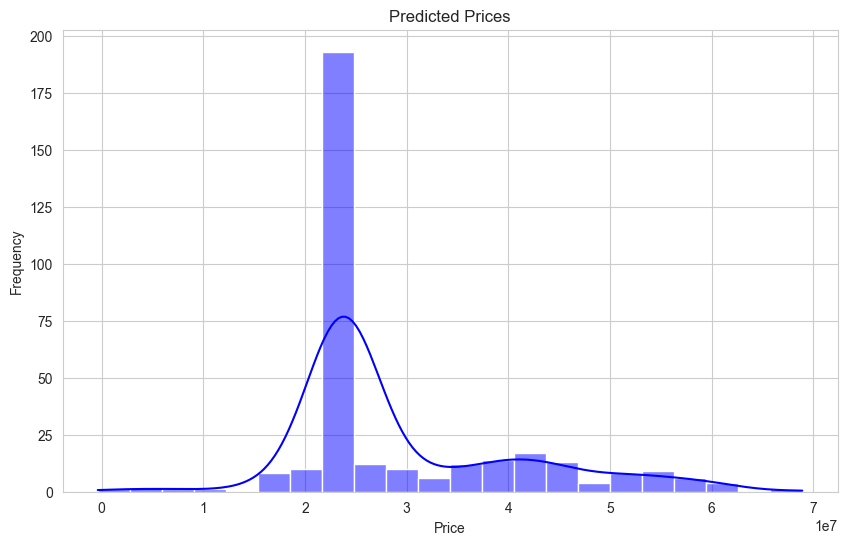

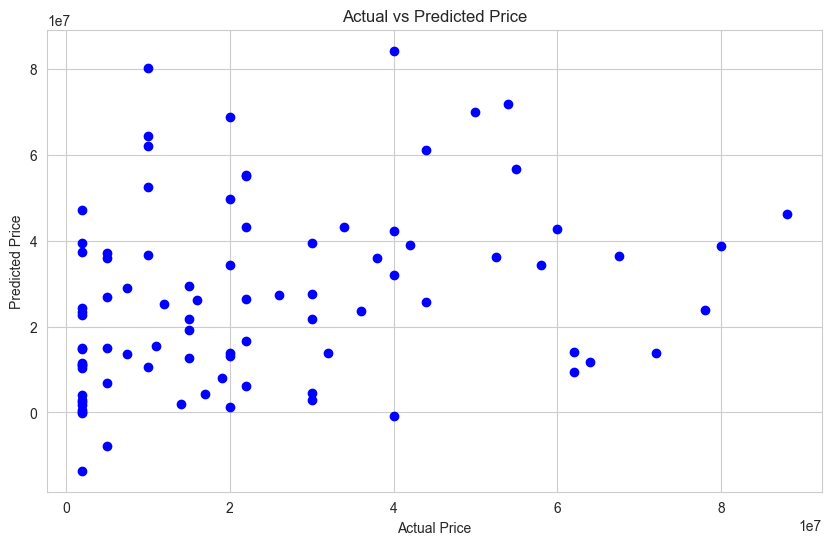

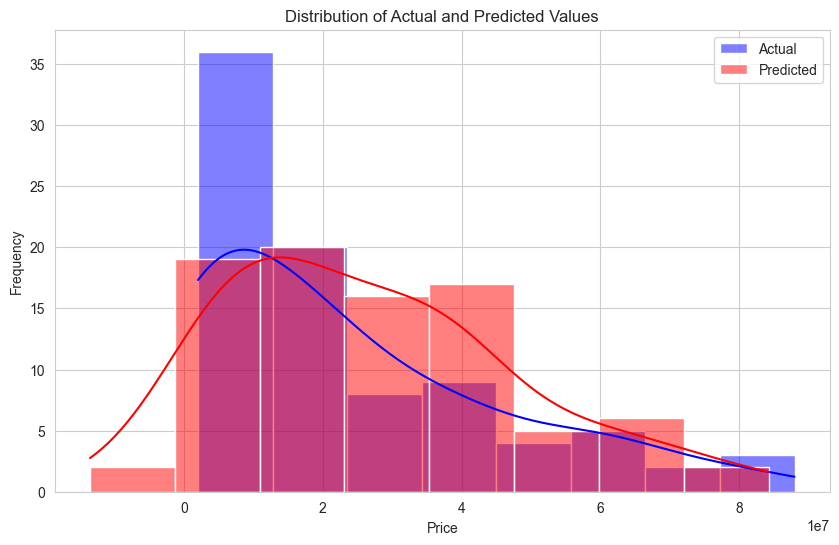

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(predictions, color='blue', kde=True)
plt.title('Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Actual vs Predicted Prices for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, color='blue')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# Distribution of the actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True)
sns.histplot(preds, color='red', label='Predicted', kde=True)
plt.title('Distribution of Actual and Predicted Values')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Define the search space
space = {
    'eta': hp.loguniform('eta', -5, 0),  # Exponentially spaced between e^-5 and e^0
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'lambda': hp.loguniform('lambda', -2, 2),
    'alpha': hp.loguniform('alpha', -2, 2)
}

# Objective function to minimize
def objective(params):
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        objective='reg:squarederror',
        **params
    )
    xgb_model.fit(x_train, y_train)
    preds = xgb_model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return {'loss': rmse, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
rng = np.random.default_rng(42)  # Using default_rng instead of RandomState
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rng)

print("Best parameters found: ", best)

# Convert the best parameters back to the appropriate types
best_params = {
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'min_child_weight': best['min_child_weight'],
    'gamma': best['gamma'],
    'lambda': best['lambda'],
    'alpha': best['alpha']
}

# Train the final model with the best parameters
best_model = xgb.XGBRegressor(
    n_estimators=100,
    objective='reg:squarederror',
    **best_params
)
best_model.fit(x_train, y_train)

# Predictions and RMSE
predictions = best_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {rmse}')


100%|██████████| 50/50 [00:04<00:00, 10.84trial/s, best loss: 23586316.0]
Best parameters found:  {'alpha': 0.5654945293943124, 'colsample_bytree': 0.7484682050306589, 'eta': 0.36350116814977074, 'gamma': 0.3305716445029222, 'lambda': 0.7076261492312568, 'max_depth': 0, 'min_child_weight': 5.861342155214897, 'subsample': 0.9437387635495996}
Test RMSE: 25950772.0


100%|██████████| 50/50 [00:08<00:00,  6.15trial/s, best loss: 24685844.0]
Best parameters found:  {'alpha': 0.13833903007800577, 'colsample_bytree': 0.9654645922376281, 'eta': 0.010000865889154272, 'gamma': 0.28204426530143745, 'lambda': 0.17200095606367435, 'max_depth': 6, 'min_child_weight': 6.474242459540229, 'subsample': 0.7901264064371525}
Test RMSE: 23877824.0
Relative RMSE: 1.0178200006484985


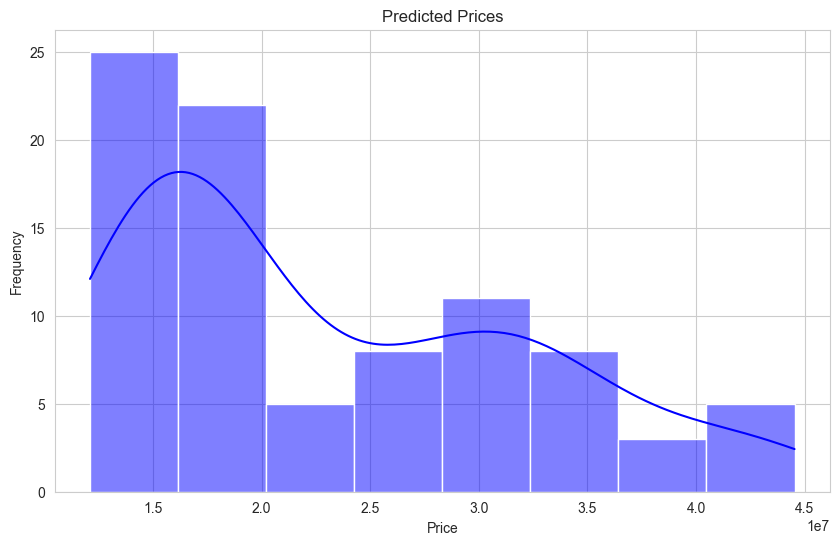

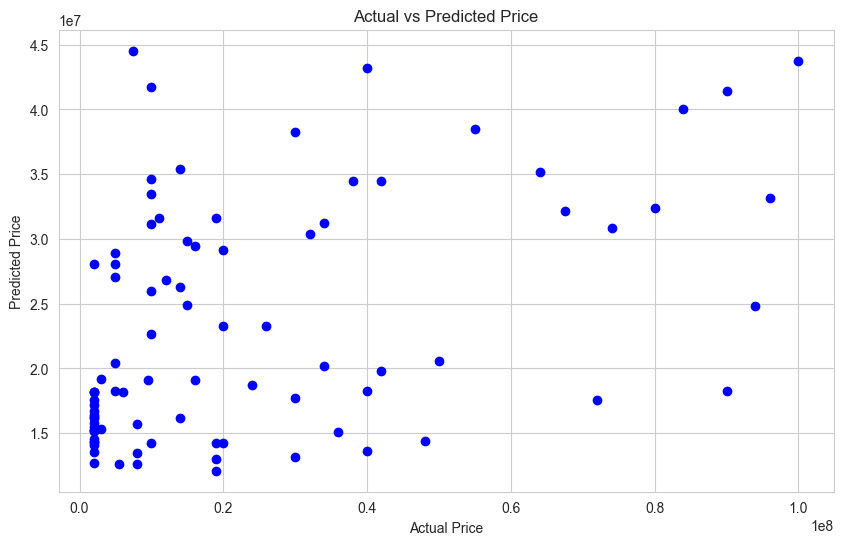

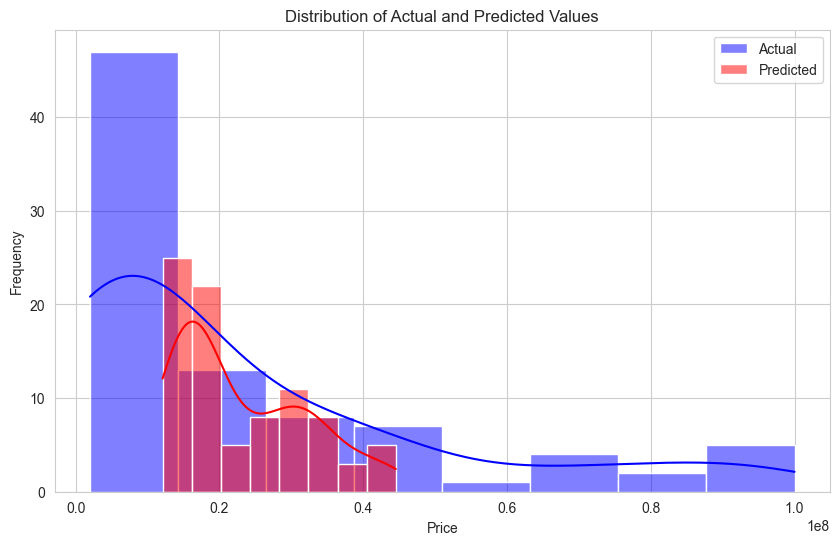

In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

# Load and preprocess the data
auction_2024 = pd.read_csv('C:/Users/radek/Downloads/ipl_auction_2024.csv')
auction_2024.set_index('Player', inplace=True)

ipl_stats_1 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2022_2023.csv')
ipl_stats_2 = pd.read_csv('C:/Users/radek/Downloads/ipl_stats_2008_2023.csv')
it20_stats_1 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2022_2023.csv')
it20_stats_2 = pd.read_csv('C:/Users/radek/Downloads/it20_stats_2005_2023.csv')

# Index by player name
for df in [ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2]:
    df.set_index('Player', inplace=True)

# Drop played for country column if it exists
for df in [ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2]:
    if 'Played For Country' in df.columns:
        df.drop('Played For Country', axis=1, inplace=True)

# Renaming the columns to make them unique
ipl_stats_1.columns = ['ipl 1 ' + col for col in ipl_stats_1.columns]
ipl_stats_2.columns = ['ipl 2 ' + col for col in ipl_stats_2.columns]
it20_stats_1.columns = ['it20 1 ' + col for col in it20_stats_1.columns]
it20_stats_2.columns = ['it20 2 ' + col for col in it20_stats_2.columns]

# Reset index for merging
for df in [auction_2024, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2]:
    df.reset_index(inplace=True)

# Merge datasets
data_2024 = pd.concat([auction_2024, ipl_stats_1, ipl_stats_2, it20_stats_1, it20_stats_2], axis=1, sort=False)

# Convert DOB to age
auction_date = pd.to_datetime('2023-12-19')
data_2024['Age'] = (auction_date - pd.to_datetime(data_2024['dob'])).dt.days // 365
data_2024.drop('dob', axis=1, inplace=True)
data_2024['Age'].fillna(data_2024['Age'].mean(), inplace=True)
data_2024.fillna(0, inplace=True)

# Select numeric columns
numeric_columns = data_2024.select_dtypes(include=[np.number]).columns
X = data_2024[numeric_columns].values.astype("float32")

# Split into training and testing sets
data = data.sample(frac=1, random_state=42).reset_index(drop=True)
x_train, x_test, y_train, y_test = train_test_split(data.drop('Amount', axis=1), data['Amount'], test_size=0.3, random_state=42)

# Convert to numpy arrays
x_train = x_train.values.astype("float32")
x_test = x_test.values.astype("float32")
y_train = y_train.values.astype("float32")
y_test = y_test.values.astype("float32")

# Reserve 10% of the training data for validation
x_val = x_train[-(int(0.1 * len(x_train))):]
y_val = y_train[-(int(0.1 * len(y_train))):]
x_train = x_train[:-(int(0.1 * len(x_train)))]
y_train = y_train[:-(int(0.1 * len(y_train)))]

# Hyperparameter optimization
space = {
    'eta': hp.loguniform('eta', -5, 0),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'subsample': hp.uniform('subsample', 0.7, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
    'min_child_weight': hp.uniform('min_child_weight', 1, 10),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'lambda': hp.loguniform('lambda', -2, 2),
    'alpha': hp.loguniform('alpha', -2, 2)
}

def objective(params):
    xgb_model = xgb.XGBRegressor(
        n_estimators=100,
        objective='reg:squarederror',
        **params
    )
    xgb_model.fit(x_train, y_train)
    preds = xgb_model.predict(x_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    return {'loss': rmse, 'status': STATUS_OK}

trials = Trials()
rng = np.random.default_rng(42)
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials, rstate=rng)

print("Best parameters found: ", best)

# Convert the best parameters back to the appropriate types
best_params = {
    'eta': best['eta'],
    'max_depth': int(best['max_depth']),
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'min_child_weight': best['min_child_weight'],
    'gamma': best['gamma'],
    'lambda': best['lambda'],
    'alpha': best['alpha']
}

# Train the final model with the best parameters
best_model = xgb.XGBRegressor(
    n_estimators=100,
    objective='reg:squarederror',
    **best_params
)
best_model.fit(x_train, y_train)

# Predictions and RMSE
predictions = best_model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Test RMSE: {rmse}')

# Calculate relative RMSE
mean_price = np.mean(y_test)
relative_rmse = rmse / mean_price
print(f'Relative RMSE: {relative_rmse}')

# Plotting the predictions
plt.figure(figsize=(10, 6))
sns.histplot(predictions, color='blue', kde=True)
plt.title('Predicted Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Actual vs Predicted Prices for Test Set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, color='blue')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Price')
plt.show()

# Distribution of the actual and predicted values
plt.figure(figsize=(10, 6))
sns.histplot(y_test, color='blue', label='Actual', kde=True)
sns.histplot(predictions, color='red', label='Predicted', kde=True)
plt.title('Distribution of Actual and Predicted Values')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.legend()
plt.show()
